# 1. Plotting wordcloud to get an idea of important words  

In [118]:
#data wrangling packages
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import random 
random.seed(13)
import sqlite3

#visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline
import seaborn as sns

In [119]:
conn = sqlite3.connect('/Users/behrouz/Desktop/Harvard/Week 2/Class 2/section2/data/section2/database.sqlite')
papers = pd.read_sql_query("select * from papers", conn)

In [120]:
papers.columns = ['id','years','title','event_type','pdf_name','abstract','paper_text']
#papers

In [121]:
# For the word colud analysis we have considered papers' title.  

features=['title']
papers=papers.loc[:,features]


#removing undesired words from the data 
papers['title'] = papers['title'].str.replace('Abstract Missing','')
papers['title'] = papers['title'].str.replace('Using','')
papers['title'] = papers['title'].str.replace('using','')
papers['title'] = papers['title'].str.replace("New",'')
papers['title'] = papers['title'].str.replace("Based",'')
papers['title'] = papers['title'].str.replace('Use','')
papers['title'] = papers['title'].str.replace('Used','')
papers['title'] = papers['title'].str.replace('Method','')
papers['title'] = papers['title'].str.replace('Problem','')
papers['title'] = papers['title'].str.replace('Approach','')
papers['title'] = papers['title'].str.replace('Model','')
papers['title'] = papers['title'].str.replace('Models','')
papers['title'] = papers['title'].str.replace('via','')

papers=papers.sample(frac=1,random_state=0)

# print(papers.shape)
print(papers.head(10))

                                                  title
39    Neural Networks for Template Matching: Applica...
794    Surface Learning with Applications to Lipreading
1585  Optimizing Correlation Algorithms for Hardware...
2899  Combining Graph Laplacians for Semi--Supervise...
5773  Evaluating the statistical significance of bic...
5913  Scheduled Sampling for Sequence Prediction wit...
1364     Combining Classifiers  Correspondence Analysis
4808  Learning Image Descriptors with the Boosting-T...
4674  Scaled Gradients on Grassmann Manifolds for Ma...
3534  ing the effects of memory on human online sent...


In [122]:
train_qs = pd.Series(papers['title'].tolist()).astype(str)

qs_text = "".join(train_qs)

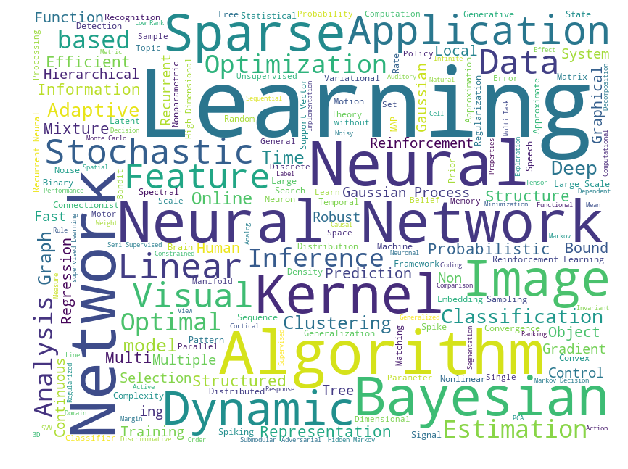

In [123]:
from wordcloud import WordCloud  #pip install wordcloud

cloud =WordCloud(font_path=None, width=800, height=600, margin=2, ranks_only=None, 
                 prefer_horizontal=0.9, mask=None, scale=1, color_func=None, max_words=200, 
                 min_font_size=4, stopwords=None, random_state=None, background_color='white', 
                 max_font_size=None, font_step=1, mode='RGB', relative_scaling=.5, regexp=None, 
                 collocations=True, colormap=None, normalize_plurals=bool, contour_width=0, 
                 contour_color='black', repeat=None).generate(str(qs_text))
print(cloud)
plt.figure(figsize=(14,8))
plt.imshow(cloud);
plt.axis('off');
#Word Clouds on a image - https://github.com/amueller/word_cloud/blob/master/examples/alice_colored.png

# 2. Running t-SNE model and plot

In [124]:
#For t-SNE model and plot, we have considered papers "title" and papers "abstract".

#Loading data from database.sqlite. 
conn = sqlite3.connect('/Users/behrouz/Desktop/Harvard/Week 2/Class 2/section2/data/section2/database.sqlite')
papers = pd.read_sql_query("select * from papers", conn)
papers.columns = ['id','years','title','event_type','pdf_name','abstract','paper_text']
features=['title','abstract']

#Removing undesired words that have been used frequently in the papers "abstract". 
papers['abstract'] = papers['abstract'].str.replace('Abstract Missing','')
papers['abstract'] = papers['abstract'].str.replace('using','')
papers['abstract'] = papers['abstract'].str.replace("show",'')
papers['abstract'] = papers['abstract'].str.replace("based",'')
papers['abstract'] = papers['abstract'].str.replace('use','')
papers['abstract'] = papers['abstract'].str.replace('used','')
papers['abstract'] = papers['abstract'].str.replace('method','')
papers['abstract'] = papers['abstract'].str.replace('problem','')
papers['abstract'] = papers['abstract'].str.replace('approach','')
papers['abstract'] = papers['abstract'].str.replace('provide','')
papers['abstract'] = papers['abstract'].str.replace('model','')

papers=papers.loc[:,features]
papers.loc[:,'title'] = papers.title.apply(lambda x: x.lower())
papers.loc[:,'abstract'] = papers.abstract.apply(lambda x: x.lower())
print(papers.head())

                                               title abstract
0  self-organization of associative database and ...         
1  the capacity of the kanerva associative memory...         
2  supervised learning of probability distributio...         
3              constrained differential optimization         
4  towards an organizing principle for a layered ...         


In [125]:
#Remove chars that are not letters or numbers
import re
regex = re.compile('\n')
papers.loc[:,'title'] = papers.title.apply(lambda x: regex.sub(' ',x))
papers.loc[:,'abstract'] = papers.abstract.apply(lambda x: regex.sub(' ',x))
print(papers.head())

                                               title abstract
0  self-organization of associative database and ...         
1  the capacity of the kanerva associative memory...         
2  supervised learning of probability distributio...         
3              constrained differential optimization         
4  towards an organizing principle for a layered ...         


In [126]:
#Remove stop words
from nltk.corpus import stopwords  #pip install nltk
stops = set(stopwords.words("english")) #stops
stops = stops.union(['I'])

In [127]:
papers.loc[:,'title'] = papers['title'].apply(lambda x: x.split(' ')) 
papers.loc[:,'title'] = papers['title'].apply(lambda x: [word for word in x if word not in stops])

papers.loc[:,'abstract'] = papers['abstract'].apply(lambda x: x.split(' ')) 
papers.loc[:,'abstract'] = papers['abstract'].apply(lambda x: [word for word in x if word not in stops])

In [128]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['title','abstract']:
        for sentence in data[col].iteritems():
            corpus.append(sentence[1])
            
    return corpus

corpus = build_corpus(papers)        
corpus[0:4]

[['self-organization', 'associative', 'database', 'applications'],
 ['capacity', 'kanerva', 'associative', 'memory', 'exponential'],
 ['supervised',
  'learning',
  'probability',
  'distributions',
  'neural',
  'networks'],
 ['constrained', 'differential', 'optimization']]

In [129]:
len(corpus)

14482

In [130]:
from gensim.models import word2vec  #pip install word2vec

model = word2vec.Word2Vec(corpus, size=200, window=10, min_count=500, workers=4, seed=82)

In [131]:
model.corpus_count

14482

In [132]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in sorted(model.wv.vocab):
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=50, n_components=2, init='pca', method='exact', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 8)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.xlabel('TSNE Component1')
    plt.ylabel('TSNE Component2')
    plt.show()

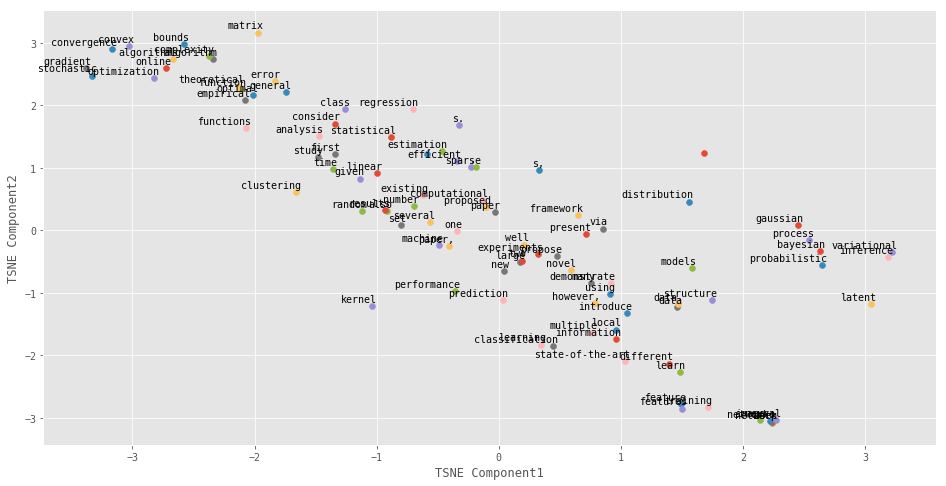

In [133]:
tsne_plot(model)

# 3. NMF for topic modeling and t-SNE for 2D-embedding

We have used 2D-embeddings to visualize the content of all NIPS papers until 2017. In doing so, we have used the method in [1] as a benchmark.

We have choosen the topics for clusters from our WordCloud analysis in the section 1 above for the words with higher appearance in NIPS papers till 2017. These topics are: 
### neural network, bayesian, clustering, optimization, learning, kernel, artificial, reinforcement, image.

[1]. https://www.kaggle.com/rjhere23/nips-papers-visualized-with-nmf-and-t-sne


In [134]:
conn = sqlite3.connect('/Users/behrouz/Desktop/Harvard/Week 2/Class 2/section2/data/section2/database.sqlite')

papers = pd.read_sql_query("select * from papers;", conn)
papers.columns = ['id','year','title','event_type','pdf_name','abstract','paper_text']

In [137]:
#For this analysis we will use "Papers Text" to identify the growth of the topics from 1997 until 2017. 

n_features = 1000
n_topics = 9
n_top_words = 10


tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=n_features,stop_words='english')


tfidf = tfidf_vectorizer.fit_transform(papers['paper_text'])


nmf = NMF(n_components=n_topics, random_state=0,alpha=.1, l1_ratio=.5).fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [138]:
nmf_embedding = nmf.transform(tfidf)
nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)

In [139]:
topics = ['neural network',
          'bayesian',
          'clustering',
          'optimization',
          'learning',
          'kernel',
          'artificial',
          'reinforcement',
          'image']        

In [140]:
tsne = TSNE(random_state=3211)
tsne_embedding = tsne.fit_transform(nmf_embedding)
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
tsne_embedding['hue'] = nmf_embedding.argmax(axis=1)

In [141]:
###code used to create the plot for getting the colors 
#plt.style.use('ggplot')

 
colors = np.array([[ 0.89411765,  0.10196079,  0.10980392,  1. ],
                   [ 0.22685121,  0.51898501,  0.66574396,  1. ],
                   [ 0.38731259,  0.57588621,  0.39148022,  1. ],
                   [ 0.7655671 ,  0.38651289,  0.37099578,  1. ],
                   [ 1.        ,  0.78937332,  0.11607843,  1. ],
                   [ 0.75226453,  0.52958094,  0.16938101,  1. ],
                   [ 0.92752019,  0.48406   ,  0.67238756,  1. ],
                   [ 0.60000002,  0.60000002,  0.60000002,  1. ],
                   [ 0.51898501,  0.22685121,  0.92752019,  1. ]])

legend_list = []

for i in range(len(topics)):   
    color = colors[i]
    legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))

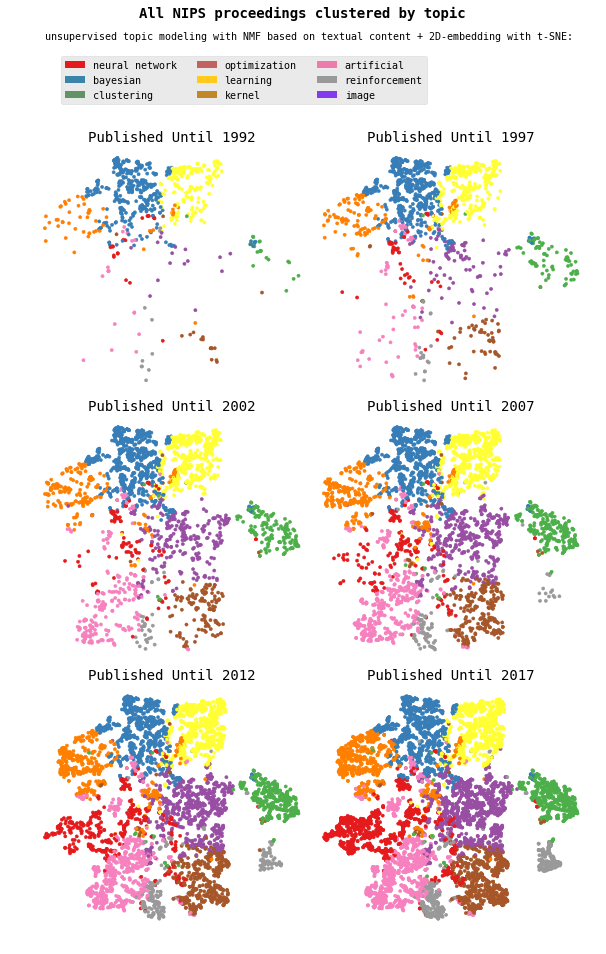

In [142]:
matplotlib.rc('font',family='monospace')
plt.style.use('ggplot')


fig, axs = plt.subplots(3,2, figsize=(10, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0)

axs = axs.ravel()

count = 0
legend = []
for year, idx in zip([1992,1997,2002,2007,2012,2017], range(6)):
    data = tsne_embedding[papers['year']<=year]
    scatter = axs[idx].scatter(data=data,x='x',y='y',s=10,c=data['hue'],cmap="Set1")
    axs[idx].set_title('Published Until {}'.format(year),**{'fontsize':'14'})
    axs[idx].axis('off')

plt.suptitle("All NIPS proceedings clustered by topic",**{'fontsize':'14','weight':'bold'})
plt.figtext(.51,0.95,'unsupervised topic modeling with NMF based on textual content + 2D-embedding with t-SNE:', **{'fontsize':'10','weight':'light'}, ha='center')

fig.legend(legend_list,topics,loc=(0.1,0.89),ncol=3)
plt.subplots_adjust(top=0.85)

plt.show()
